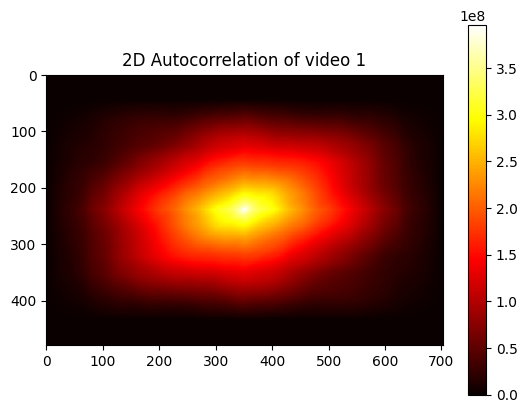

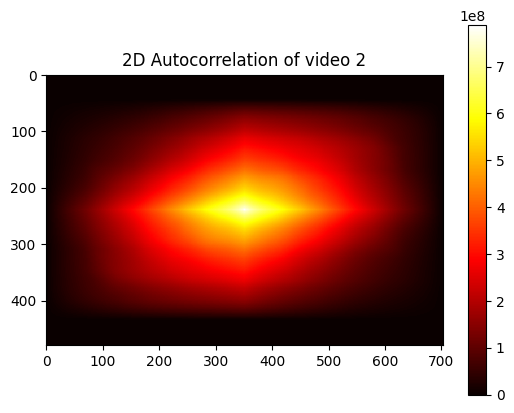

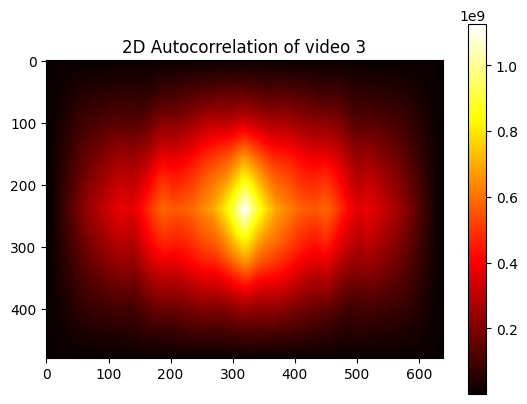

In [2]:
import av
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

def autocorrelate_2d(frame):
    frame_gray = np.mean(frame, axis=2)
    autocorr = correlate2d(frame_gray, frame_gray, mode='full')
    return autocorr

def autocorrelate(input_video_path):
    with av.open(input_video_path) as container:
        for frame in container.decode(video=0):
            frame_array = np.array(frame.to_image())
            autocorr_result = autocorrelate_2d(frame_array)
            return autocorr_result

for i in range(1, 4):
    input_video_path = f'lr1_{i}.AVI'
    autocorr_result = autocorrelate(input_video_path)

    plt.imshow(autocorr_result, cmap='hot', interpolation='nearest')
    plt.title(f'2D Autocorrelation of video {i}')
    plt.colorbar()
    plt.show()
    plt.close()

